In [5]:
!ls
!nvidia-smi
#!unzip dogs-vs-cats.zip
#!unzip train.zip
#!mv train kaggle_data
#!rm -f test1.zip train.zip sampleSubmission.csv

2_5395669557429928845.ipynb	    Project(SGD1).ipynb
Cats-vs-Dogs--Keras-Tutorial.ipynb  Report_CNN_DNN.ipynb
CNN(CPU_only).ipynb		    Sifar10x3(onCpu).ipynb
CNN.ipynb			    Sifar10x3(onGpu).ipynb
CNN(jhub2_GPU3).ipynb		    Sifar10x6(onCpu).ipynb
CNN(jhub2).ipynb		    Sifar10x6(on GPU).ipynb
data
Wed Dec 25 23:41:34 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:1A:00.0 Off |                    0 |
| N/A   35C    P0    54W / 300W |  32377MiB / 32480MiB |      0%      Default |
+------------------------------

В качестве практического примера рассмотрим классификацию изображений собак и кошек из набора данных, содержащего 4000 изображений (2000 кошек, 2000 собак). 

Будем использовать 2000 изображений для обучения, 1000 для проверки и 1000 для контроля.создан в ходе состязаний по распознаванию образов в конце 2013-го, и доступен на сайте Kaggle. 
Этот набор содержит изображения в формате JPEG с низким разрешением. 

Этот набор содержит 25 000 изображений кошек и собак

будем использовать менее 10% данных

 Лучшие результаты достигали точности в 95 %
www.kaggle.com/c/dogs-vs-cats/data 

In [4]:
import os, shutil

original_dataset_dir = 'kaggle_data'
base_dir = 'cats_vs_dogs'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')

test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')


подсчитаем, сколько изображений оказалось в каждом поднаборе

In [5]:

print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))

print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))


total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


In [6]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
from matplotlib import pyplot as plt

import os
import json
import random
import numpy as np
import pandas as pd
import cv2

from pandas import date_range, Series, DataFrame, read_csv, qcut
from numpy.random import randn

import tensorflow as tf
import tensorflow.keras

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, SeparableConv2D
from tensorflow.keras.layers import Convolution2DTranspose, concatenate
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing import image

print (tf.__version__)
print (tf.keras.__version__)
print(cv2.__version__)


2.0.0
2.2.4-tf
4.1.1


Наши данные хранятся в виде файлов JPEG, поэтому их нужно подготовить для передачи в сеть, выполнив следующие шаги: 
1. Прочитать файлы с изображениями. 
2. Декодировать содержимое из формата JPEG в таблицы пикселов RGB. 
3. Преобразовать их в тензоры с вещественными числами. 
4. Масштабировать значения пикселов из диапазона [0, 255] в диапазон [0, 1] 

Во фреймворке Keras имеется модуль keras.preprocessing.image с инструментами для обработки изображений. 

Примеры изображений из набора «Dogs vs. Cats»
Изображения имеют разные размеры, ракурсы съемки и т.д.


['cats_vs_dogs/train/cats/cat.761.jpg', 'cats_vs_dogs/train/cats/cat.282.jpg', 'cats_vs_dogs/train/cats/cat.726.jpg', 'cats_vs_dogs/train/cats/cat.507.jpg', 'cats_vs_dogs/train/dogs/dog.256.jpg', 'cats_vs_dogs/train/dogs/dog.260.jpg', 'cats_vs_dogs/train/dogs/dog.815.jpg', 'cats_vs_dogs/train/dogs/dog.151.jpg']


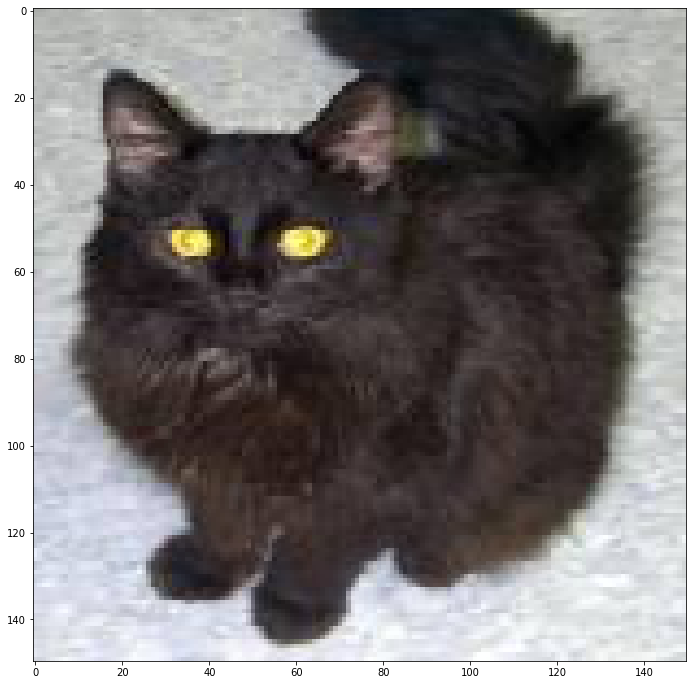

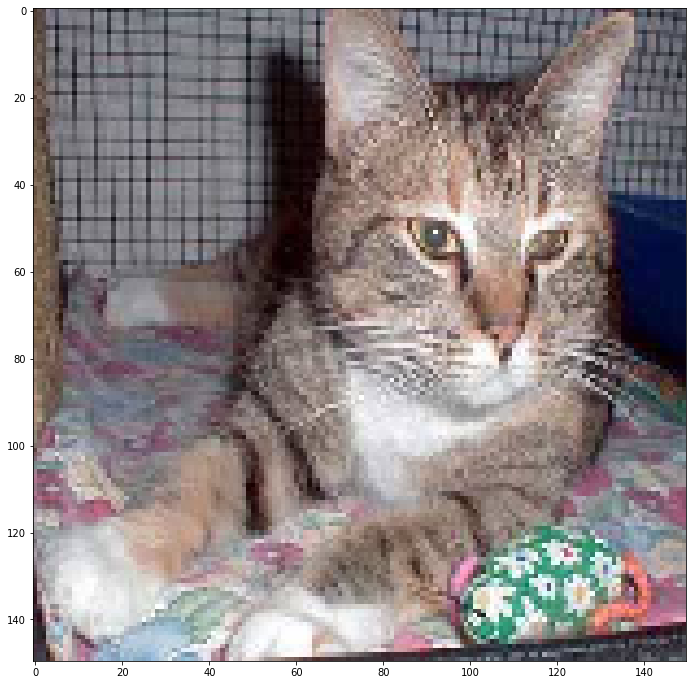

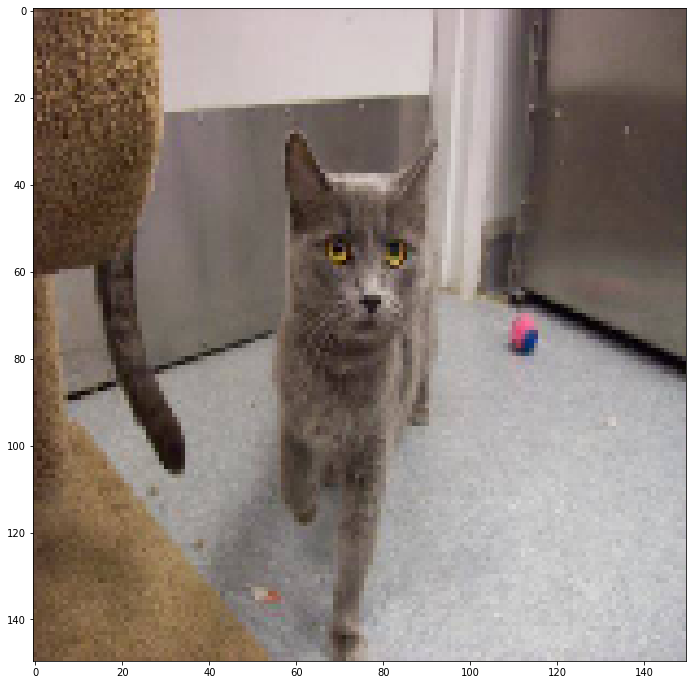

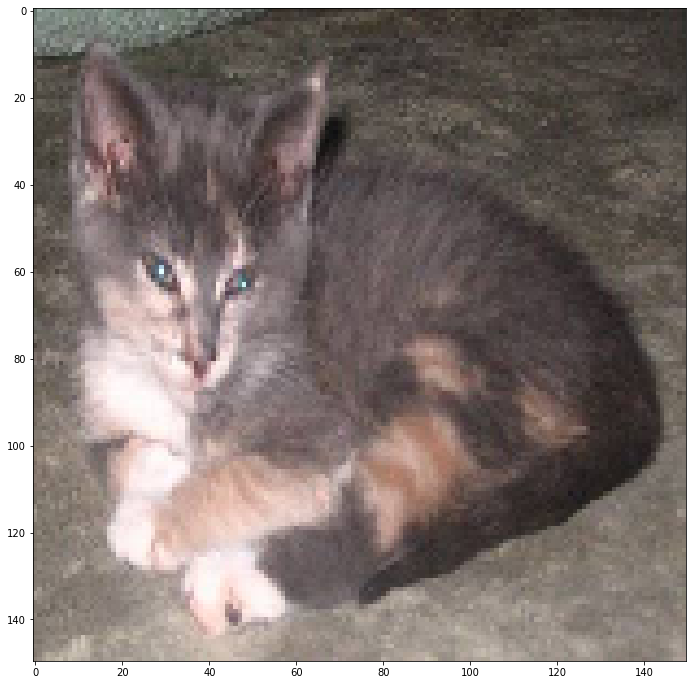

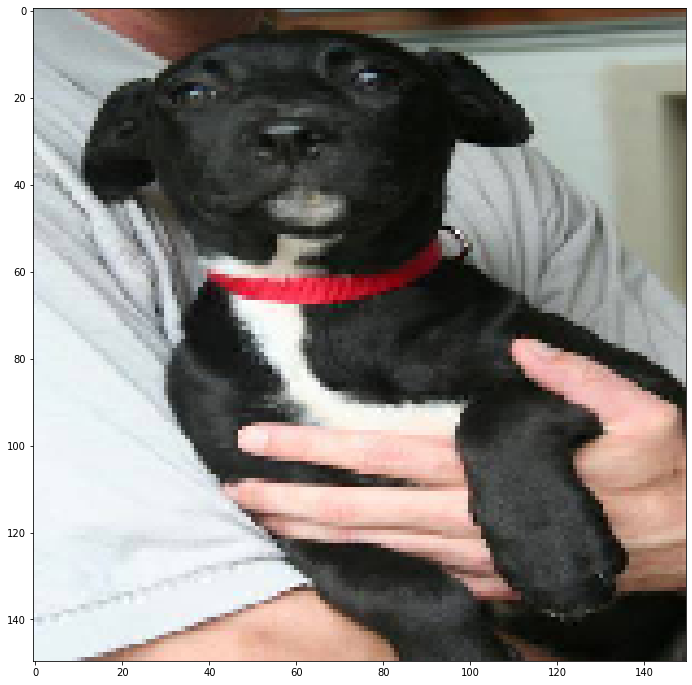

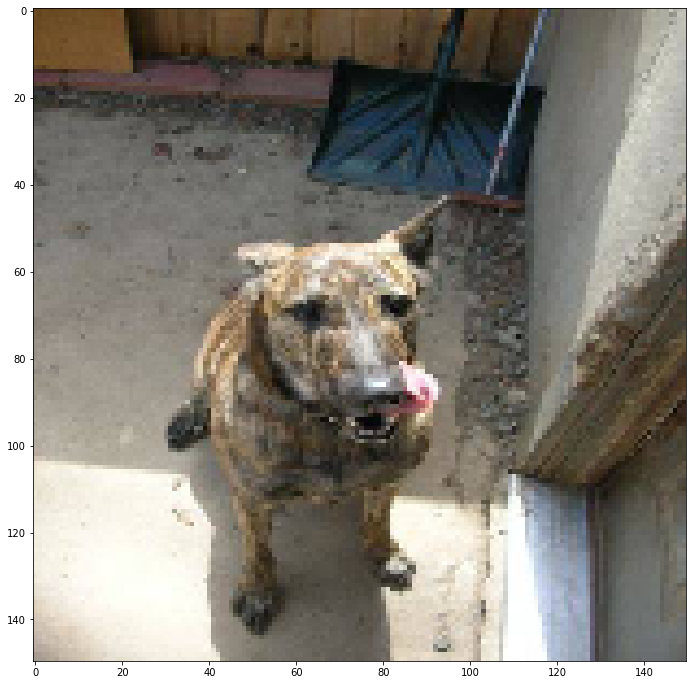

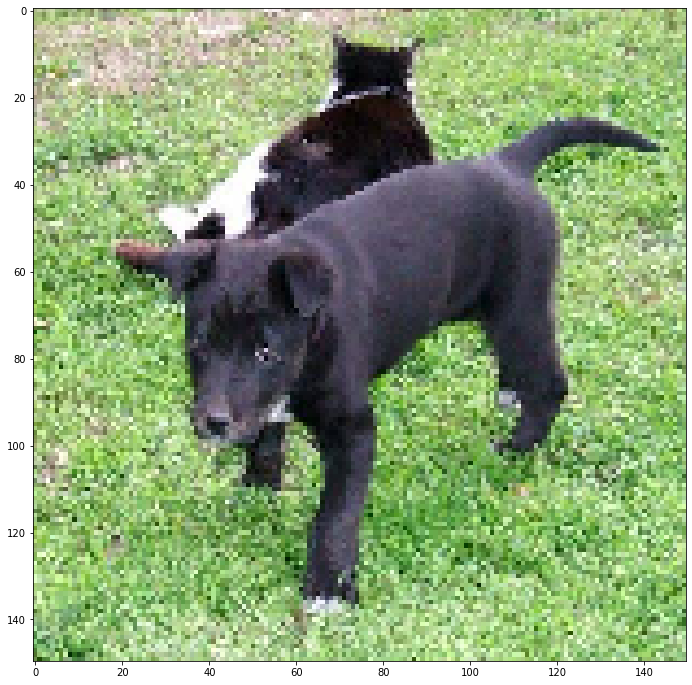

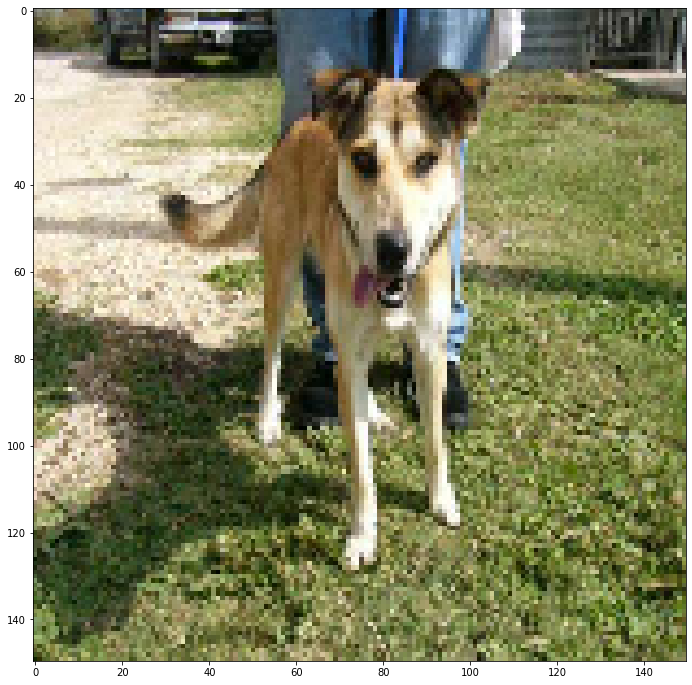

In [7]:
from tensorflow.keras.preprocessing import image

### Kotiki
cats_list = os.listdir(train_cats_dir)[:4]
fnames = [os.path.join(train_cats_dir, kname) for kname in cats_list]

### Soba4ki
dogs_list = os.listdir(train_dogs_dir)[:4]
for dname in dogs_list:
    fnames.append(os.path.join(train_dogs_dir, dname))
    
print(fnames)
for i, img_path in enumerate(fnames):
    img = image.load_img(img_path, target_size=(150, 150))
    x = image.img_to_array(img) # Преобразование в массив Numpy с формой (150,150,3)
    #print(x.shape)
    plt.figure(figsize = (12, 12))
    imgplot = plt.imshow(image.array_to_img(x))       
plt.show()


Конструирование сети
реализуем структуру: сверточная нейронная сеть будет организована как стек чередующихся слоев Conv2D (с функцией активации relu) и MaxPooling2D. 

Hачнем с входов, имеющих размер 150 × 150 (выбор был сделан совершенно произвольно), в конце, точно перед слоем Flatten, получится карта признаков размером 7 × 7.

Глубина карт признаков в сети будет постепенно увеличиваться (с 32 до 128), а их размеры — уменьшаться (со 148 × 148 до 7 × 7). Этот шаблон вы будете видеть почти во всех сверточных нейронных сетях

Так как перед нами стоит задача бинарной классификации, сеть должна заканчиваться единственным признаком (слой Dense с размером 1 и функцией активации sigmoid). Этот признак будет представлять собой вероятность принадлежности рассматриваемого изображения одному из двух классов.


Тип задачи -- Функция активации для последнего уровня -- Функция потерь

Бинарная классификация -- sigmoid -- binary_crossentropy 
Многоклассовая, однозначная классификация -- softmax -- categorical_crossentropy 
Многоклассовая, многозначная классификация -- sigmoid -- binary_crossentropy 
Регрессия по произвольным значениям -- Нет -- mse 
Регрессия по значениям  между 0 и 1 -- sigmoid -- mse или binary_crossentropy

https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a


In [47]:
from tensorflow.keras.models import Model

input_shape = (150, 150, 3)
kernel_size = 3
pool_size = 2

inp = Input(shape = input_shape) #(depth, height, width)) # N.B. depth goes first in Keras!

# Conv [32] -> Pool (with dropout on the pooling layer)
conv_1 = Conv2D(32, (kernel_size, kernel_size), activation = 'relu')(inp)
pool_1 = MaxPooling2D(pool_size = (pool_size, pool_size))(conv_1)

conv_2 = Conv2D(64, (kernel_size, kernel_size), activation = 'relu')(pool_1)
pool_2 = MaxPooling2D(pool_size = (pool_size, pool_size))(conv_2)

conv_3 = Conv2D(128, (kernel_size, kernel_size), activation = 'relu')(pool_2)
pool_3 = MaxPooling2D(pool_size = (pool_size, pool_size))(conv_3)

conv_4 = Conv2D(128, (kernel_size, kernel_size), activation = 'relu')(pool_3)
pool_4 = MaxPooling2D(pool_size = (pool_size, pool_size))(conv_4)

# Now flatten to 1D, apply FC -> ReLU (with dropout) -> softmax
flat = Flatten()(pool_4)

#  den1 = tf.keras.layers.Dense(2048, use_bias=False)(flat)
dense_1 = Dense(512, activation = 'relu')(flat)
#drop_3 = Dropout(1 - drop_prob_2)(dense_1)
out = Dense(1, activation = 'sigmoid')(dense_1)

model = Model(inputs = inp, outputs = out) # To define a model, just specify its input and output layers

model.summary()

model.compile(loss = 'binary_crossentropy', # using the cross-entropy loss function
              optimize = 'adam', # using the Adam optimiser
              metrics = ['accuracy']) # reporting the accuracy

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 36, 36, 64)        0   

класс ImageDataGenerator, который позволит быстро настроить генераторы Python для автоматического преобразования файлов с изображениями в пакеты готовых тензоров.

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
###Генератором в языке Python называется объект, действующий как итератор: его можно использовать с инструкцией цикла for ... in.

train_datagen = ImageDataGenerator(rescale =1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150), # Привести все изображения к размеру 150×150
    batch_size = 20, class_mode = 'binary')

valid_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [51]:
### Checkpoint for model
checkpoint = ModelCheckpoint(
    'checkpoint.h5', 
    monitor = 'accuracy', 
    verbose = 0, 
    save_best_only = False, 
    save_weights_only = False,
    mode = 'auto'
)

####
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### Train 
history = model.fit_generator(
    train_generator,
    validation_data = valid_generator,
    callbacks = [checkpoint],
    use_multiprocessing = True,
    workers = 1,
    epochs = 30
)



Epoch 1/30
100/100 [==============================] - 9s 88ms/step - loss: 1.0625 - accuracy: 0.5040 - val_loss: 0.6952 - val_accuracy: 0.5000
Epoch 2/30
100/100 [==============================] - 6s 64ms/step - loss: 0.6876 - accuracy: 0.5720 - val_loss: 0.6506 - val_accuracy: 0.6230
Epoch 3/30
100/100 [==============================] - 6s 64ms/step - loss: 0.6484 - accuracy: 0.6335 - val_loss: 0.6559 - val_accuracy: 0.5730
Epoch 4/30
100/100 [==============================] - 7s 66ms/step - loss: 0.6054 - accuracy: 0.6810 - val_loss: 0.5837 - val_accuracy: 0.7060
Epoch 5/30
100/100 [==============================] - 7s 66ms/step - loss: 0.5777 - accuracy: 0.7080 - val_loss: 0.5954 - val_accuracy: 0.7000
Epoch 6/30
100/100 [==============================] - 7s 65ms/step - loss: 0.5262 - accuracy: 0.7420 - val_loss: 0.5669 - val_accuracy: 0.7070
Epoch 7/30
100/100 [==============================] - 7s 65ms/step - loss: 0.4849 - accuracy: 0.7605 - val_loss: 0.6159 - val_accuracy: 0.7090

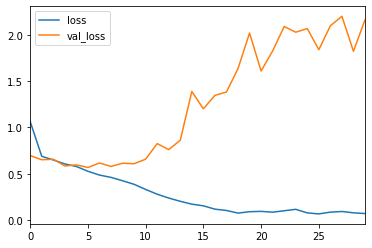

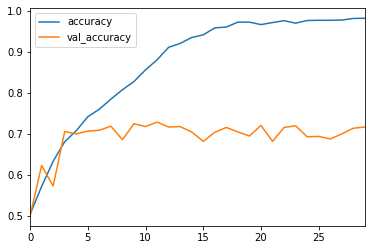

In [52]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()

### Save the weights
model.save_weights('cat_vs_dos_00.h5')

На графиках четко наблюдается эффект переобучения. Точность на обучающих данных линейно растет и приближается к 100 %, тогда как точность на проверочных данных останавливается на отметке 70–71%

Причиной переобучения является недостаточное количество образцов для обучения модели, способной обобщать новые данные. 
Имея бесконечный объем данных, можно было бы получить модель, учитывающую все аспекты распределения данных: эффект переобучения никогда не наступил бы. 
Прием расширения данных(data augmentation) реализует подход создания дополнительных обучающих данных из имеющихся путем трансформации образцов множеством случайных преобразований, дающих правдоподобные изображения. Цель состоит в том, чтобы на этапе обучения модель никогда не увидела одно и то же изображение дважды. Это поможет модели выявить больше особенностей данных и достичь лучшей степени обобщения. 

Сделать это в Keras можно путем настройки ряда случайных преобразований для изображений, читаемых экземпляром ImageDataGenerator.

In [36]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

cats_vs_dogs/train/cats/cat.726.jpg


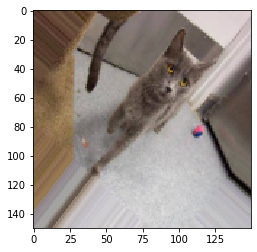

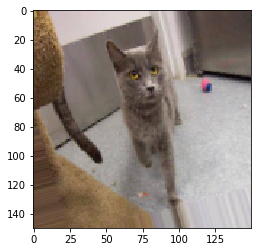

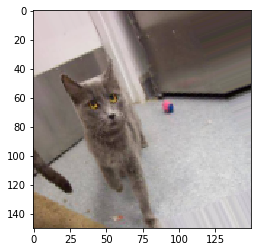

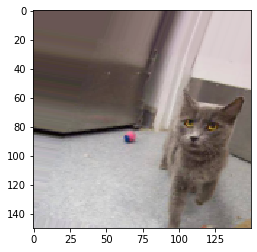

In [64]:
img_path = fnames[2]
print(img_path)

img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img) # Преобразование в массив Numpy с формой (150, 150, 3)
x = np.expand_dims(x, axis = 0) # Изменение формы на (1, 150, 150, 3)

bi = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(bi)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    bi += 1
    if bi % 4 == 0:
        break
plt.show()


Если обучить новую сеть с использованием этих настроек расширения данных, она никогда не увидит одно и то же изображение дважды. Однако входные данные попрежнему будут тесно связаны между собой, потому что получены из небольшого количества оригинальных изображений, — у вас не получится сгенерировать новую информацию, вы можете только повторить существующую. Поэтому данного решения недостаточно, чтобы избавиться от эффекта переобучения. 

Продолжая борьбу с ним, добавим в модель слои Dropout.

In [8]:
input_shape = (150, 150, 3)
kernel_size = 3
pool_size = 2
drop_prob_1 = 0.3

inp = Input(shape = input_shape) #(depth, height, width)) # N.B. depth goes first in Keras!

# Conv [32] -> Pool (with dropout on the pooling layer)
conv_1 = Conv2D(32, (kernel_size, kernel_size), activation = 'relu')(inp)
pool_1 = MaxPooling2D(pool_size = (pool_size, pool_size))(conv_1)
drop_1 = Dropout(drop_prob_1)(pool_1)

conv_2 = Conv2D(64, (kernel_size, kernel_size), activation = 'relu')(drop_1)
pool_2 = MaxPooling2D(pool_size = (pool_size, pool_size))(conv_2)
drop_2 = Dropout(drop_prob_1)(pool_2)

conv_3 = Conv2D(128, (kernel_size, kernel_size), activation = 'relu')(drop_2)
pool_3 = MaxPooling2D(pool_size = (pool_size, pool_size))(conv_3)

conv_4 = Conv2D(128, (kernel_size, kernel_size), activation = 'relu')(pool_3)
pool_4 = MaxPooling2D(pool_size = (pool_size, pool_size))(conv_4)

# Now flatten to 1D, apply FC -> ReLU (with dropout) -> softmax
flat = Flatten()(pool_4)

dense_1 = Dense(512, activation = 'relu')(flat)
drop_3 = Dropout(0.5)(dense_1)
out = Dense(1, activation = 'sigmoid')(drop_3)

model2 = Model(inputs = inp, outputs = out) # To define a model, just specify its input and output layers

model2.summary()

model2.compile(loss = 'binary_crossentropy', # using the cross-entropy loss function
              optimize = 'adam', # using the Adam optimiser
              metrics = ['accuracy']) # reporting the accuracy

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0     

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
 train_dir, 
 target_size=(150, 150), 
 batch_size=16,
 class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
 validation_dir,
 target_size=(150, 150),
 batch_size=16,
 class_mode='binary'
)

os.environ['CUDA_VISIBLE_DEVICES'] = '1,2'

history2 = model2.fit_generator(
 train_generator,
 steps_per_epoch=100,
 epochs=60,
 validation_data=validation_generator
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/60
100/100 [==============================] - 13s 128ms/step - loss: 0.7695 - accuracy: 0.5169 - val_loss: 0.6920 - val_accuracy: 0.5490
Epoch 2/60
100/100 [==============================] - 11s 106ms/step - loss: 0.7015 - accuracy: 0.5362 - val_loss: 0.6793 - val_accuracy: 0.5610
Epoch 3/60
100/100 [==============================] - 11s 107ms/step - loss: 0.6836 - accuracy: 0.5769 - val_loss: 0.7016 - val_accuracy: 0.5430
Epoch 4/60
100/100 [==============================] - 11s 106ms/step - loss: 0.6851 - accuracy: 0.5569 - val_loss: 0.7621 - val_accuracy: 0.5830
Epoch 5/60
100/100 [==============================] - 11s 106ms/step - loss: 0.6741 - accuracy: 0.5831 - val_loss: 0.6697 - val_accuracy: 0.5550
Epoch 6/60
100/100 [==============================] - 11s 107ms/step - loss: 0.6629 - accuracy: 0.6169 - val_loss: 0.6259 - val_accuracy: 0.6670
Epoch 7/60
100/100 [==========================

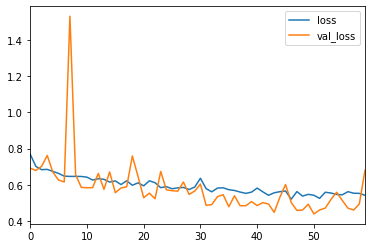

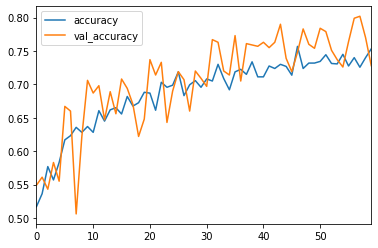

In [15]:
history2_df = pd.DataFrame(history2.history)
history2_df[['loss', 'val_loss']].plot()
history2_df[['accuracy', 'val_accuracy']].plot()

### Save the weights
model2.save('cat_vs_dos_01.h5')


 Применив расширение данных и прореживание, мы практически избавились от переобучения: кривые точности и потерь на этапе обучения близки к аналогичным кривым на этапе проверки. Теперь мы достигли точности почти 80%, улучшив ее в сравнении с нерегуляризованной моделью.

Типичным и эффективным подходом к глубокому обучению на небольших наборах изображений является использование предварительно обученной сети. Предварительно обученная сеть — это сохраненная сеть, прежде обученная на большом наборе данных, обычно в рамках масштабной задачи классификации изображений. Если этот исходный набор данных достаточно велик и достаточно обобщен, тогда пространственная иерархия признаков, изученных сетью, может эффективно выступать в роли обобщенной модели видимого мира и быть полезной во многих разных задачах распознавания образов, даже если эти новые задачи будут связаны с совершенно иными классами, отличными от классов в оригинальной задаче. Другими словами, можно обучить сеть на изображениях из ImageNet (где подавляющее большинство классов — животные и бытовые предметы) и затем использовать эту обученную сеть для идентификации чего-то иного, например предметов мебели на изображениях. Такая переносимость изученных признаков между разными задачами — главное преимущество глубокого обучения перед многими более старыми приемами поверхностного обучения, которое делает глубокое обучение очень эффективным инструментом для решения задач с малым объемом данных.

В нашем случае мы возьмем за основу сверточную нейронную сеть, обученную на наборе ImageNet (1,4 миллиона изображений, классифицированных на 1000 разных классов). 

Мы воспользуемся архитектурой VGG16
это простая и широко используемая архитектура сверточной нейронной сети для обучения на коллекции ImageNet

Модель VGG16 входит в состав фреймворка Keras. Ее можно импортировать из модуля keras.applications. Вот список моделей классификации изображений (все они предварительно обучены на наборе ImageNet), доступных в keras .applications: 

 Xception 
 Inception V3 
 ResNet50 
 VGG16 
 VGG19 
 MobileNet

Есть два приема использования предварительно обученных сетей: выделение признаков (feature extraction) и дообучение (fine-tuning). 

In [16]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 11s 0us/step


сверточные нейронные сети, используемые для классификации изображений, состоят из двух частей: они начинаются с последовательности слоев выбора значений и свертки и заканчиваются полносвязным классификатором. Первая часть называется сверточной основой (convolutional base) модели. В случае со сверточными нейронными сетями процесс выделения признаков заключается в том, чтобы взять сверточную основу предварительно обученной сети, пропустить через нее новые данные и на основе вывода обучить новый классификатор 

карты признаков сверточной нейронной сети — это карты присутствия на изображениях обобщенных понятий, которые могут пригодиться независимо от конкретной задачи распознавания образов. Но представления, изученные классификатором, обязательно будут характерны для набора классов, на котором обучалась модель, — они будут содержать только информацию о вероятности присутствия того или иного класса на изображении. Кроме того, представления, присутствующие в полносвязных слоях, не содержат никакой информации о местоположении  объекта на исходном изображении (эти слои лишены понятия пространства), тогда как сверточные карты признаков все еще хранят ее. Для задач, где местоположение объектов имеет значение, полносвязные признаки почти бесполезны. 

уровень обобщенности (и, соответственно, пригодности к повторному использованию) представлений, выделенных конкретными сверточными слоями, зависит от глубины слоя в модели. Слои, следующие первыми, выделяют локальные, наиболее обобщенные карты признаков (таких, как визуальные границы, цвет и текстура), тогда как слои, располагающиеся дальше (или выше), выделяют более абстрактные понятия (такие, как «глаз кошки» или «глаз собаки»).

In [17]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     


Рассмотрим  прием выделения признаков, более медленный и затратный, но позволяющий использовать расширение данных в процессе обучения, — прием расширения модели conv_base и ее использования для классификации.

Так как модели действуют подобно слоям, вы можете добавить модель (такую, как conv_base) в модель Sequential как самый обычный слой.


In [24]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers

model3 = Sequential()
model3.add(conv_base)
model3.add(layers.Flatten())
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


Перед компиляцией и обучением модели очень важно заморозить сверточную основу. Замораживание одного или нескольких слоев предотвращает изменение весовых коэффициентов в них в процессе обучения. Если этого не сделать, тогда представления, прежде изученные сверточной основой, изменятся в процессе обучения на новых данных. Так как слои Dense сверху инициализируются случайными значениями, в сети могут произойти существенные изменения весов, фактически разрушив представления, полученные ранее. В Keras, чтобы заморозить сеть, нужно передать атрибут trainable со значением False

In [25]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model3.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable weights '
    'after freezing the conv base:', len(model3.trainable_weights))


This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


Epoch 1/30
100/100 [==============================] - 11s 112ms/step - loss: 0.7814 - accuracy: 0.6812 - val_loss: 0.3215 - val_accuracy: 0.8662
Epoch 2/30
100/100 [==============================] - 10s 104ms/step - loss: 0.5065 - accuracy: 0.7500 - val_loss: 0.3359 - val_accuracy: 0.8562
Epoch 3/30
100/100 [==============================] - 10s 102ms/step - loss: 0.4440 - accuracy: 0.7831 - val_loss: 0.3739 - val_accuracy: 0.8413
Epoch 4/30
100/100 [==============================] - 10s 102ms/step - loss: 0.4084 - accuracy: 0.8163 - val_loss: 0.3212 - val_accuracy: 0.8600
Epoch 5/30
100/100 [==============================] - 10s 101ms/step - loss: 0.4178 - accuracy: 0.8012 - val_loss: 0.2803 - val_accuracy: 0.8850
Epoch 6/30
100/100 [==============================] - 10s 101ms/step - loss: 0.3826 - accuracy: 0.8238 - val_loss: 0.2705 - val_accuracy: 0.8925
Epoch 7/30
100/100 [==============================] - 10s 104ms/step - loss: 0.3918 - accuracy: 0.8225 - val_loss: 0.2899 - val_ac

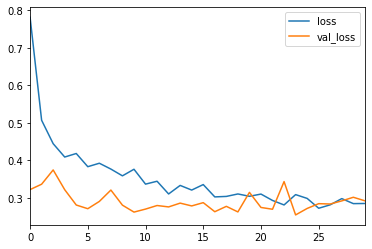

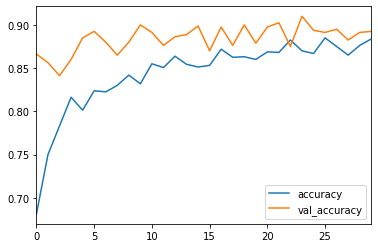

In [26]:
model3.compile(loss = 'binary_crossentropy', # using the cross-entropy loss function
              optimize = 'adam', # using the Adam optimiser
              metrics = ['accuracy']) # reporting the accuracy

history3 = model3.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50
)
history3_df = pd.DataFrame(history3.history)
history3_df[['loss', 'val_loss']].plot()
history3_df[['accuracy', 'val_accuracy']].plot()


Мы достигли точности, близкой к 90 %, — более высокой, чем в предыдущем разделе, где обучали небольшую модель с нуля. 


Другой широко используемый прием повторного использования модели, дополняющий выделение признаков, — дообучение (fine-tuning)
Дообучение заключается в размораживании нескольких верхних слоев замороженной модели, которая использовалась для выделения признаков, и совместном обучении вновь добавленной части модели (в данном случае полносвязного классификатора) и этих верхних слоев. Этот прием называется дообучением, поскольку немного корректирует наиболее абстрактные представления в повторно используемой модели, чтобы сделать их более актуальными для данной задачи. Выше я отмечал, что необходимо заморозить сверточную основу сети VGG16, чтобы получить возможность обучить классификатор, инициализированный случайными значениями. По той же причине после обучения классификатора можно дообучить несколько верхних слоев сверточной основы. Если классификатор еще не обучен, ошибочный сигнал, распространяющийся по сети в процессе дообучения, окажется слишком велик, и представления, полученные на предыдущем этапе обучения, будут разрушены. Для дообучения сети требуется выполнить следующие шаги: 
1. Добавить свою сеть поверх обученной базовой сети. 
2. Заморозить базовую сеть. 
3. Обучить добавленную часть.
4. Разморозить несколько слоев в базовой сети. 
5. Обучить эти слои и добавленную часть вместе.

Дообучим три последних сверточных слоя, то есть все слои выше block4_pool нужно заморозить, а слои block5_conv1, block5_conv2 и block5_conv3 — сделать доступными для обучения. Почему бы не дообучить больше слоев? Почему бы не дообучить всю сверточную основу? Так можно поступить, но имейте в виду следующее. 

 Начальные слои в сверточной основе кодируют более обобщенные признаки, пригодные для повторного использования, а более высокие слои кодируют более конкретные признаки. Намного полезнее донастроить более конкретные признаки, потому что именно их часто нужно перепрофилировать для решения новой задачи. Ценность дообучения нижних слоев быстро падает с их глубиной. 
 Чем больше параметров обучается, тем выше риск переобучения. Сверточная основа имеет 15 миллионов параметров, поэтому было бы слишком рискованно пытаться дообучить ее целиком на нашем небольшом наборе данных. 

In [27]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [28]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        

In [34]:
from tensorflow.keras import optimizers

model3.compile(loss = 'binary_crossentropy', # using the cross-entropy loss function
              optimizer = optimizers.Adam(lr = 1e-5),
              metrics = ['accuracy']) # reporting the accuracy


Epoch 1/100
100/100 [==============================] - 11s 110ms/step - loss: 0.2874 - accuracy: 0.8775 - val_loss: 0.2581 - val_accuracy: 0.8988
Epoch 2/100
100/100 [==============================] - 10s 104ms/step - loss: 0.2330 - accuracy: 0.9000 - val_loss: 0.2586 - val_accuracy: 0.9013
Epoch 3/100
100/100 [==============================] - 10s 102ms/step - loss: 0.2183 - accuracy: 0.9087 - val_loss: 0.2592 - val_accuracy: 0.9062
Epoch 4/100
100/100 [==============================] - 10s 101ms/step - loss: 0.2308 - accuracy: 0.9031 - val_loss: 0.2368 - val_accuracy: 0.9087
Epoch 5/100
100/100 [==============================] - 10s 102ms/step - loss: 0.1843 - accuracy: 0.9262 - val_loss: 0.2338 - val_accuracy: 0.9150
Epoch 6/100
100/100 [==============================] - 10s 101ms/step - loss: 0.1843 - accuracy: 0.9250 - val_loss: 0.3122 - val_accuracy: 0.8763
Epoch 7/100
100/100 [==============================] - 10s 103ms/step - loss: 0.1727 - accuracy: 0.9319 - val_loss: 0.2605 -

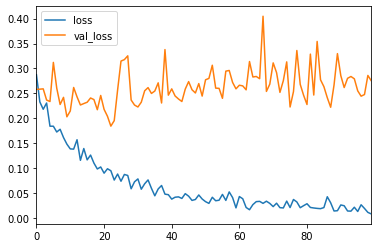

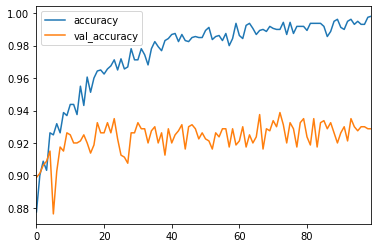

In [35]:
history4 = model3.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)

history4_df = pd.DataFrame(history4.history)
history4_df[['loss', 'val_loss']].plot()
history4_df[['accuracy', 'val_accuracy']].plot()

Здесь мы получили точность на уровне 93%

Теперь наконец можно оценить модель на контрольных данных: 0.934%

In [38]:
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size = (150, 150),                                              
    batch_size = 20,                                           
    class_mode = 'binary'                                              
)

test_loss, test_acc = model3.evaluate_generator(test_generator, steps = 50)
print('test acc:', test_acc)


Found 1000 images belonging to 2 classes.
test acc: 0.934
